# Bar Reviews

![antio.jpg](img/antio.jpg)
$^{1}$Image credit: https://www.zumarraga.eus/es/

Feb, 2023
> *Web Scraping, Data Analysis, Machine Learning, Sentiment Analysis*

## Background
I wanted to do sentiment analysis with reviews written in Spanish. But I couldn't use `TextBlob` library, because this out-of-the-box package is trained in English. Therefore, I had to build my own machine learning model to have a positive-or-negative-opinion classifier in Spanish.

Also, for the model to be trained, I needed enough reviews both good and bad. A special place came to mind, a very nice [bar-restaurant](https://bidebide.eus/) in my town, that I personally appreciate very much but [receives polarised reviews](https://goo.gl/maps/uGGQiSVaB4aYw8h86) from customers.






In [80]:
# Import basic packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Auxiliaries
import time
import datetime
from IPython.display import Markdown

# Selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

# Parsing
from bs4 import BeautifulSoup

# Sentiment analysis, Scikit-learn
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

## Web scraping the data
I had to scrape the reviews from this site in Google Maps. The webpage is dynamic, meaning I had to write some lines of code to sequentially operate on it, scrolling down pages and clicking on buttons before fetching the information.

![antio-bidebide.png](img/antio-bidebide.png)

In [81]:
# Start the session
service = Service(executable_path="/driver") # chromedriver.exe location
driver = webdriver.Chrome(service=service)

# Navigate to the webpage
url = "https://www.google.com/maps/place/Bar-Restaurante+Bidebide+-+Zumarraga/@43.0916521,-2.3038457,15z/data=!4m7!3m6!1s0x0:0xbbdffd835d70d9e4!8m2!3d43.0916521!4d-2.3038457!9m1!1b1"
driver.get(url)

# Agree with cookies in Google consent page
driver.find_element(by=By.XPATH,
                    value='//*[@id="yDmH0d"]/c-wiz/div/div/div/div[2]/div[1]/div[3]/div[1]/div[1]/form[2]/div/div/button/span')\
                    .click()

# Request page title
title = driver.title
print(f"Page title -> {title}")

# Find the total number of reviews
number_reviews = driver.find_element(by=By.XPATH,
                                     value='//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]/div/div[2]/div[2]')

n_reviews = int(number_reviews.text.split(" ")[0])

# Find scrollable element
scrollable_div = driver.find_element(by=By.XPATH,
                                     value='//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]')

# Scroll down as many times as necessary to load all reviews
for i in range(0,(round(n_reviews/10 - 1))):
    driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scrollable_div)
    time.sleep(1)

# Click 'Más' buttons to reveal complete text of reviews
buttons = driver.find_elements(by=By.TAG_NAME,
                               value="button")
for button in buttons:
    if button.text == "Más":
        button.click()
        
# Wait
time.sleep(5)


# Parse html page
soup = BeautifulSoup(driver.page_source)

# Init
names = []
dates = []
stars = []
texts = []

# Search for the data
for review in soup.find_all('div', attrs={'jstcache':'393'}):
    
    # Extract stars
    star = review.find('span', attrs={'class':'kvMYJc'})
    if star is None:
        stars.append('')
    else:
        star = star["aria-label"]
        stars.append(star)
    
    # Extract name
    name = review.find('span', attrs={'jstcache':'358'})
    if name is None:
        names.append('')
    else:
        name = name.get_text(strip=True)
        names.append(name)
    
    # Extract date
    date = review.find('span', attrs={'jstcache':'139'})
    if date is None:
        dates.append('')
    else:
        date = date.get_text(strip=True)
        dates.append(date)
    
    # Extract text
    text = review.find('span', attrs={'jstcache':'292'})
    if text is None:
        dates.append('')
    else:
        text = text.get_text(strip=True)
        texts.append(text)

    

# Store listed reviews in a pandas dataframe
antio = pd.DataFrame({"name": names, "date": dates, "stars": stars, "text": texts})

# End browser the session
driver.quit()

# Display dataframe
antio

Page title -> Bar-Restaurante Bidebide - Zumarraga - Google Maps


,name,date,stars,text
0,Alberto Urtaza,Hace un año,4 estrellas,Excelente trato y buena relación precio-calida...
1,Mikel Landa,Hace 5 meses,5 estrellas,Muy buen menú con mucha variedad y buen produc...
2,Francisco Javier Martin Mateo,Hace 4 meses,4 estrellas,"Comida buenísima y buena atención, vistas mara..."
3,VICTOR T O,Hace 7 meses,5 estrellas,"He comido el menú del día por 13 euros, y tien..."
4,Mari Carmen Merino,Hace 3 meses,4 estrellas,Restaurante grande con unos menús muy ricos y ...
...,...,...,...,...
454,Aitor R,Hace 7 meses,4 estrellas,
455,sheila perez,Hace 8 meses,5 estrellas,
456,Alejandro Alban,Hace un año,3 estrellas,
457,Cristhian Frutos,Hace 2 años,3 estrellas,


## Data processing
The acquired data needed some processing before proceeding with the analysis:
- Extract stars as an integer from the string type stars column.
- Convert date to the year in which the review was written.
- Rearrange the pandas dataframe: desired columns, names, order, index.
- Finally, fill in missing (NaN) values in text with empty strings.

In [82]:
# Convert stars column from string to number
antio["stars_n"] = [stars[1] for stars in antio["stars"]]
antio["stars_n"] = antio["stars_n"].astype(str).astype(int)

# Convert date to the year in which the review was written
years = []

for text in antio["date"]:
    
    # Replace "u" to "1"
    if text[5] == "u":
        number = "1"
    else:
        number = text[5:7] # Number may take 2 characters
    
    # Calculate year from "months ago"
    actual_month = datetime.date.today().month
    actual_year = datetime.date.today().year
    
    if "mes" in text:
        if (actual_month - int(number)) < 0:
            year = actual_year - 1
        else:
            year = actual_year
            
    # Calculate year from "years ago"      
    elif "año" in text:
        year = actual_year - int(number)
    
    # Append to list of years
    years.append(year)

antio["date_n"] = years

# Rearrange dataframe with columns name, date, stars, text
antio = antio.iloc[:, [0, 5, 4, 3]]
antio = antio.rename(columns={"date_n": "date", "stars_n": "stars"})
antio = antio.set_index("date")

# Replace missing values
antio = antio.fillna("")

# Show dataframe info
print(antio.info())

# Print head
antio.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 2022 to 2021
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    459 non-null    object
 1   stars   459 non-null    int32 
 2   text    459 non-null    object
dtypes: int32(1), object(2)
memory usage: 12.6+ KB
None


,name,stars,text
date,,,
2022,Alberto Urtaza,4,Excelente trato y buena relación precio-calida...
2022,Mikel Landa,5,Muy buen menú con mucha variedad y buen produc...
2022,Francisco Javier Martin Mateo,4,"Comida buenísima y buena atención, vistas mara..."
2022,VICTOR T O,5,"He comido el menú del día por 13 euros, y tien..."
2022,Mari Carmen Merino,4,Restaurante grande con unos menús muy ricos y ...


## Data analysis

### Number of reviews per year

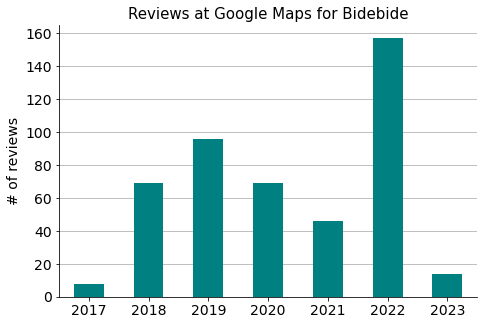

In [83]:
# Count reviews per year
reviews_yearly = antio.groupby(antio.index)["name"].count()

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

reviews_yearly.plot(ax=ax, kind="bar", color="teal")

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Reviews at Google Maps for Bidebide", size=15)
ax.set_xlabel("")
ax.set_ylabel("# of reviews", size=14)
sns.despine()

plt.show()

Distribution over the years of the number of reviews on Google Maps.

### Stars’ distribution

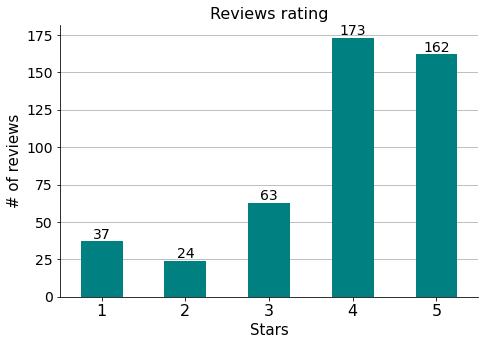

In [84]:
# Count stars
stars_count = antio["stars"].value_counts().to_frame()

# Define a dataframe with all possibilities: 1, 2, 3, 4, 5 stars
frame = pd.DataFrame(index=[1, 2, 3, 4, 5])

# Merge them to build a dataframe ready to plot
stars = frame.merge(stars_count, how="left",
                    left_on=frame.index, right_on=stars_count.index)
stars = stars.rename(columns={"key_0": "rate", "stars": "number"})
stars = stars.set_index("rate").fillna(0).astype(int)

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

stars.plot(ax=ax, kind="bar", color="teal")

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=16, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Reviews rating", size=16)
ax.set_xlabel("Stars", size=15)
ax.set_ylabel("# of reviews", size=15)
ax.bar_label(ax.containers[0], size=14)
ax.legend().set_visible(False)
sns.despine()

plt.show()

Let's calculate the total score.

In [85]:
# Calculate de average value of rating
n_reviews = stars["number"].sum()
rating = 0

for stars, number in zip(stars.index, stars["number"]):
    rating += stars * number
    
rating = rating / n_reviews

display(Markdown(f"General rating --> **{rating:.1f}**"))

General rating --> **3.9**

Which has to be the same rating score that is calculated and shown on Google.

## Sentiment analysis

### Data labeling

To build the model, we first we have to label the reviews as:  

- 0 : if the review is negative.
- 1 : if the review is positive.

Depending on the quantity, reading each text and assigning it the corresponding label can become tedious. Anyway, at this stage this task cannot be automated and needs to be done by a human intelligence (a simple job, also known as *Mechanical Turk*).

For my convenience, though, I will trust customers and I am going to automate it, considering as positive the reviews with 4 or 5 stars —so reviews with 1, 2 or 3 stars will be considered negative.

In [86]:
# Copy to a new dataframe only reviews containing text
antiox = antio[antio["text"] != ""].copy()

# Print how many were selected
print(f"{len(antiox)} 'texted' reviews out of {len(antio)} were selected.")

# Create new column with labels according to number of stars
antiox["label"] = [0 if star < 4 else 1 for star in antiox["stars"]]

# Rearrange dataframe to containn only label and text, renamed "review"
antiox = antiox.reset_index().iloc[:, [4, 3]]
antiox = antiox.rename(columns={"text": "review"})

antiox

193 'texted' reviews out of 459 were selected.


,label,review
0,1,Excelente trato y buena relación precio-calida...
1,1,Muy buen menú con mucha variedad y buen produc...
2,1,"Comida buenísima y buena atención, vistas mara..."
3,1,"He comido el menú del día por 13 euros, y tien..."
4,1,Restaurante grande con unos menús muy ricos y ...
...,...,...
188,1,(Traducido por Google) Gran lugar\n\n(Original...
189,1,(Traducido por Google) Increíble vista\n\n(Ori...
190,1,(Traducido por Google) Hermoso menú y temperat...
191,1,(Traducido por Google) Gran lugar\n\n(Original...


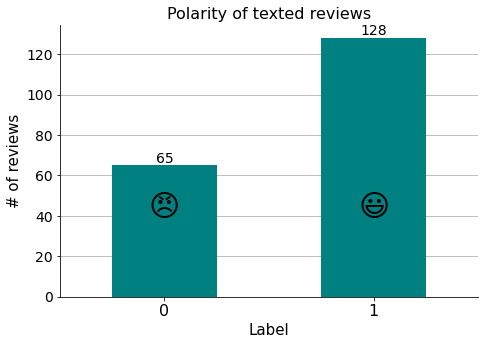

In [87]:
# Count plot
fig, ax = plt.subplots(figsize=(7.5, 5))

antiox["label"].value_counts().sort_values().plot(ax=ax, kind="bar", color="teal")

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=16, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Polarity of texted reviews", size=16)
ax.set_xlabel("Label", size=15)
ax.set_ylabel("# of reviews", size=15)
ax.bar_label(ax.containers[0], size=14)
ax.legend().set_visible(False)
ax.annotate("\U0001F603", (1, 40), ha="center", size=30) # Smiling emoji
ax.annotate("\U0001F620", (0, 40), ha="center", size=30) # Angry emoji
sns.despine()

plt.show()

We can see that there is an imbalance in the binary target variable (the label) we would like to predict with the model. The proportion is around 1:2, and even if the imbalance is not extreme, it is going to affect the predicted results, because the class of interest is the one less represented (it is more interesting to automatically detect negative reviews, i.e. "0"s, to be notified and deal with them) and therefore there is less information available to it. I will address this issue while modelling.

### Bag-of-words
Next, we have to transform our text data to numeric form. A machine learning model cannot work with the text data directly, but rather with numeric features created from the data. A basic method is the *bag-of-words* (BOW): a bag-of-words approach describes the frequency of words within a document. It basically builds a vocabulary of the words in the document, keeping track of their frequencies (losing word order and grammar rules: it is like throwing all words in a bag!).

In [88]:
# Get list of stopwords in Spanish from file
with open("data/stopwords-spanish.txt", encoding="utf-8") as file:
    stopwords_spanish = file.read().splitlines()

# Build stopwords list for this project
stopwords = stopwords_spanish\
            + ["zumarraga", "zumárraga", "urretxu", "gipuzkoa", "google"]

# To ignore digits and only consider words of two or more letters
token_pattern=r'\b[^\d\W][^\d\W]+\b'
    
# Build and fit the vectorizer
vect = CountVectorizer(
    # Vocabulary size
    # max_features=, # Pick the n most frequent words
    # max_df=, # Ignore terms with higher than specified frequency
    # min_df=, # Ignore terms with lower than specified frequency
    # Stopwords: do not consider these words
    stop_words=stopwords,
    # Consider this pattern (ignore digits...)
    token_pattern=token_pattern,
    # Capture some context 
    ngram_range=(1, 2), # Bigrams besides unigrams
                      )

vect.fit(antiox["review"])

# Transform the review column
X_review = vect.transform(antiox["review"])

# Create the bow representation
X_df = pd.DataFrame(X_review.toarray(), columns=vect.get_feature_names_out())

# # Take a look a the list of features
# print(X_df.columns.tolist())

# Show dataframe
X_df

,abrir,abrir original,abrir ánimo,abrumado,abrumado lástima,abundante,abundante personal,acabar,acabar frerir,acabar gente,...,zerbitzatzeko ondorioz,zona,zona acerco,zumaia,zumaia arantzazu,ánimo,ánimo seguiremos,ún,ún camarero,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### New features
Having extra features besides the BOW usually results in a better model. We will add the number of individual words in each review (a measure of the length of each review).

In [89]:
# Create individual word (tokens) list for reviews (list of lists)
word_tokens = [word_tokenize(review) for review in antiox["review"]]

# Iterate over the word_tokens list
len_tokens = []
for i in range(len(word_tokens)):
    len_tokens.append(len(word_tokens[i]))
    
# Create a new feature for the length of each review
X_df["n_tokens"] = len_tokens

### Model fitting
Predicting whether a review was good or bad is a binary classification task in machine learning. When splitting the data in train and test sets, as there is an imbalance in the target classes, it is best practice to use stratified sampling to ensure the split reflects the original proportion of labels.

I will choose a Logistic Regression model because it is a standard approach in binary classifiers. To address the imbalance issue, I will instantiate the model with parameter `class_weight` assigned to "balanced", so that the model automatically adjusts weights inversely proportional to class frequencies.

In [90]:
# Define the vector of targets and matrix of features
y = antiox["label"]
X = X_df

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    stratify=y)

# Scale X data, to help converge Logistic Regression model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# Train a logistic regression
log_reg = LogisticRegression(random_state=0,
                             class_weight="balanced").fit(X_train_std, y_train)

# Make predictions on the test set
y_predicted = log_reg.predict(X_test_std)

### Model evaluation

If for example we want to automatically detect bad reviews (to raise an alert and do something about them), it is important to catch as many of them as possible. In that case, I would choose "recall" to evaluate the model: the higher the score of this metric, the higher the number of reviews that will correctly be interpreted as bad reviews.

That will come at the expense of "precision" though, as a higher sensitivity will mean more false positives (i.e. good reviews that will mistakenly be considered bad), but this is not a problem in this case (just a false alarm!).

In [91]:
# Print the performance metrics
print('Confusion matrix: \n\n', confusion_matrix(y_test, y_predicted))
print('\nReport: \n', classification_report(y_test, y_predicted,
                                           target_names=["bad reviews ->", "good reviews ->"]))

Confusion matrix: 

 [[14  6]
 [ 9 29]]

Report: 
                  precision    recall  f1-score   support

 bad reviews ->       0.61      0.70      0.65        20
good reviews ->       0.83      0.76      0.79        38

       accuracy                           0.74        58
      macro avg       0.72      0.73      0.72        58
   weighted avg       0.75      0.74      0.75        58



In [92]:
# Get recall (sensitivity) of bad reviews
display(Markdown(f'Recall (sensitivity) for bad reviews  -> **{classification_report(y_test, y_predicted, target_names=["bad reviews", "good reviews"],output_dict=True)["bad reviews"]["recall"]}**'))

Recall (sensitivity) for bad reviews  -> **0.7**

## Conclusions

In this project, reviews from a bar-restaurant were web-scraped from Google Maps, and a sentiment analysis model for texts was built.

However, a machine learning model development project like this one needs iterative testing with different algorithms and hyperparameter tuning until the desired performance is achieved. There are lots of them in the language processing area. This was not though the aim of this little project, which was just to give an initial approach on the subject.

Also —and most importantly—, a next step would involve experimenting with the business problem to decide whether the deployment into production of this machine learning tool pays off.